In [0]:
!pip install -U torch==1.5 torchvision==0.6 -f https://download.pytorch.org/whl/cu101/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
print("--------------------------------Check")
print(torch.__version__, torch.cuda.is_available())
!gcc --version
!pip install detectron2==0.1.2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/index.html

Looking in links: https://download.pytorch.org/whl/cu101/torch_stable.html
Requirement already up-to-date: torch==1.5 in /usr/local/lib/python3.6/dist-packages (1.5.0+cu101)
Requirement already up-to-date: torchvision==0.6 in /usr/local/lib/python3.6/dist-packages (0.6.0+cu101)
     |████████████████████████████████| 276kB 2.7MB/s 


In [0]:
import collections
import torch
import json
import os
import cv2
import random
import gc
import pycocotools
import numpy as np 
import pandas as pd 
from tqdm import tqdm
import matplotlib.pyplot as plt
import PIL
from PIL import Image, ImageFile
from torch.utils.data import Dataset, DataLoader

from pathlib import Path
print(cv2.__version__)
# import some common detectron2 utilities
from detectron2.structures import BoxMode
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

4.2.0


In [0]:
cfg = get_cfg()
# Merging model configs with default 
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model

# Get weights from Instance segmentation Mask RCNN R 50 FPN model
#cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")

#from detectron2.modeling import build_model
#model = build_model(cfg)
#from detectron2.checkpoint import DetectionCheckpointer
#file_path='/mount/ws/output_13May2020/model_final.pth'
#DetectionCheckpointer(model).load(file_path)   # load a file to model
cfg.MODEL.WEIGHTS = os.path.join("/mount/ws/output_13May2020", "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model
cfg.DATASETS.TEST = ('test_sample_fashion_val',)
cfg.INPUT.MIN_SIZE_TEST = 400
# Maximum size of the side of the image during testing
cfg.INPUT.MAX_SIZE_TEST = 600

# Mask type
#cfg.INPUT.MASK_FORMAT = "bitmask"  # default: "polygon"
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # default: 512
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 46  # 46 classes in iMaterialist
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
predictor = DefaultPredictor(cfg)
#print(trainer)

[05/16 20:35:03 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

FileNotFoundError: [Errno 2] No such file or directory: 'datasets/coco/annotations/instances_train2017.json'

In [0]:
#print(model)

In [0]:
def rle_decode_string(string, h, w):
    mask = np.full(h*w, 0, dtype=np.uint8)
    annotation = [int(x) for x in string.split(' ')]
    for i, start_pixel in enumerate(annotation[::2]):
        mask[start_pixel: start_pixel+annotation[2*i+1]] = 1
    mask = mask.reshape((h, w), order='F')

    
    return mask

def rle2bbox(rle, shape):
    '''
    Get a bbox from a mask which is required for Detectron 2 dataset
    rle: run-length encoded image mask, as string
    shape: (height, width) of image on which RLE was produced
    Returns (x0, y0, x1, y1) tuple describing the bounding box of the rle mask
    
    Note on image vs np.array dimensions:
    
        np.array implies the `[y, x]` indexing order in terms of image dimensions,
        so the variable on `shape[0]` is `y`, and the variable on the `shape[1]` is `x`,
        hence the result would be correct (x0,y0,x1,y1) in terms of image dimensions
        for RLE-encoded indices of np.array (which are produced by widely used kernels
        and are used in most kaggle competitions datasets)
    '''
    
    a = np.fromiter(rle.split(), dtype=np.uint)
    a = a.reshape((-1, 2))  # an array of (start, length) pairs
    a[:,0] -= 1  # `start` is 1-indexed
    
    y0 = a[:,0] % shape[0]
    y1 = y0 + a[:,1]
    if np.any(y1 > shape[0]):
        # got `y` overrun, meaning that there are a pixels in mask on 0 and shape[0] position
        y0 = 0
        y1 = shape[0]
    else:
        y0 = np.min(y0)
        y1 = np.max(y1)
    
    x0 = a[:,0] // shape[0]
    x1 = (a[:,0] + a[:,1]) // shape[0]
    x0 = np.min(x0)
    x1 = np.max(x1)
    
    if x1 > shape[1]:
        # just went out of the image dimensions
        raise ValueError("invalid RLE or image dimensions: x1=%d > shape[1]=%d" % (
            x1, shape[1]
        ))

    return x0, y0, x1, y1

In [0]:
#images_list = []
#for dirname, _, filenames in os.walk('/mount/data/train/'):
#    for filename in filenames:
#        images_list.append(os.path.join(dirname, filename))

#DATASET
data_dir = Path('/mount/data/')
image_dir = Path('/mount/data/train/')
df = pd.read_csv(data_dir/'train.csv')

# Get label descriptions
with open(data_dir/'label_descriptions.json', 'r') as file:
    label_desc = json.load(file)
df_categories = pd.DataFrame(label_desc['categories'])
df_attributes = pd.DataFrame(label_desc['attributes'])

# Get image file path and add it to our dataframe
dirname = '/mount/data/train'
df_copy = df[:40000].copy()
df_copy['ImageId'] = dirname + '/' + df_copy['ImageId'] + '.jpg'
bboxes = [rle2bbox(c.EncodedPixels, (c.Height, c.Width)) for n, c in df_copy.iterrows()]
assert len(bboxes) == df_copy.shape[0]
bboxes_array = np.array(bboxes)
df_copy['x0'], df_copy['y0'], df_copy['x1'], df_copy['y1'] = bboxes_array[:,0], bboxes_array[:,1], bboxes_array[:,2], bboxes_array[:,3]
print(df_copy.head())
del bboxes
gc.collect()

                                             ImageId  \
0  /mount/data/train/00000663ed1ff0c4e0132b9b9ac5...   
1  /mount/data/train/00000663ed1ff0c4e0132b9b9ac5...   
2  /mount/data/train/00000663ed1ff0c4e0132b9b9ac5...   
3  /mount/data/train/00000663ed1ff0c4e0132b9b9ac5...   
4  /mount/data/train/00000663ed1ff0c4e0132b9b9ac5...   

                                       EncodedPixels  Height  Width  ClassId  \
0  6068157 7 6073371 20 6078584 34 6083797 48 608...    5214   3676        6   
1  6323163 11 6328356 32 6333549 53 6338742 75 63...    5214   3676        0   
2  8521389 10 8526585 30 8531789 42 8537002 46 85...    5214   3676       28   
3  12903854 2 12909064 7 12914275 10 12919485 15 ...    5214   3676       31   
4  10837337 5 10842542 14 10847746 24 10852951 33...    5214   3676       32   

                     AttributesIds    x0    y0    x1    y1  
0  115,136,143,154,230,295,316,317  1163  3923  2839  5213  
1  115,136,142,146,225,295,316,317  1212  1371  2394  3979  

2425

In [0]:

def get_fashion_dict(df):
    
    dataset_dicts = []
    
    for idx, filename in enumerate(df['ImageId'].unique().tolist()):
        
        record = {}
        
        record['height'] = int(df[df['ImageId']==filename]['Height'].values[0])
        record['width'] = int(df[df['ImageId']==filename]['Width'].values[0])
        record['file_name'] = filename
        record['image_id'] = idx
        
        objs = []
        for index, row in df[(df['ImageId']==filename)].iterrows():
            
            # Create binary mask from EncodedPixel, Heigh, and Width columns
            mask = rle_decode_string(row['EncodedPixels'], row['Height'], row['Width'])
            
            # transform the mask from binary to polygon
            contours, hierarchy = cv2.findContours((mask).astype(np.uint8), cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
            segmentation = []

            for contour in contours:
                contour = contour.flatten().tolist()
                # segmentation.append(contour)
                if len(contour) > 4:
                    segmentation.append(contour)    
            #print(type(row['ClassId']))
            obj = {
                'bbox': [int(row['x0']), int(row['y0']), int(row['x1']), int(row['y1'])],
                'bbox_mode': BoxMode.XYXY_ABS,
                'category_id': int(row['ClassId']),
                'segmentation': segmentation, # polygon mask, as required by Detectron2 documentation
                'iscrowd': 0
            }
            objs.append(obj)
        record['annotations'] = objs
        dataset_dicts.append(record)
    return dataset_dicts

In [0]:
fashion_dict = get_fashion_dict(df_copy[33001:33100])

In [0]:
# Get a sample of the training data to run experiments
df_copy_sample = {}
df_copy_sample['train'] = df_copy[:33000].copy()
df_copy_sample['val'] = df_copy[33001:40000].copy()

In [0]:
from detectron2.data import DatasetCatalog, MetadataCatalog

# Register the train and test and set metadata
for d in ['train', 'val']:
    DatasetCatalog.register('test_sample_fashion_' + d, lambda d=df_copy_sample[d]: get_fashion_dict(d))
    MetadataCatalog.get("test_sample_fashion_" + d).set(thing_classes=list(df_categories.name))
fashion_metadata = MetadataCatalog.get("test_sample_fashion_train")

AssertionError: Dataset 'test_sample_fashion_train' is already registered!

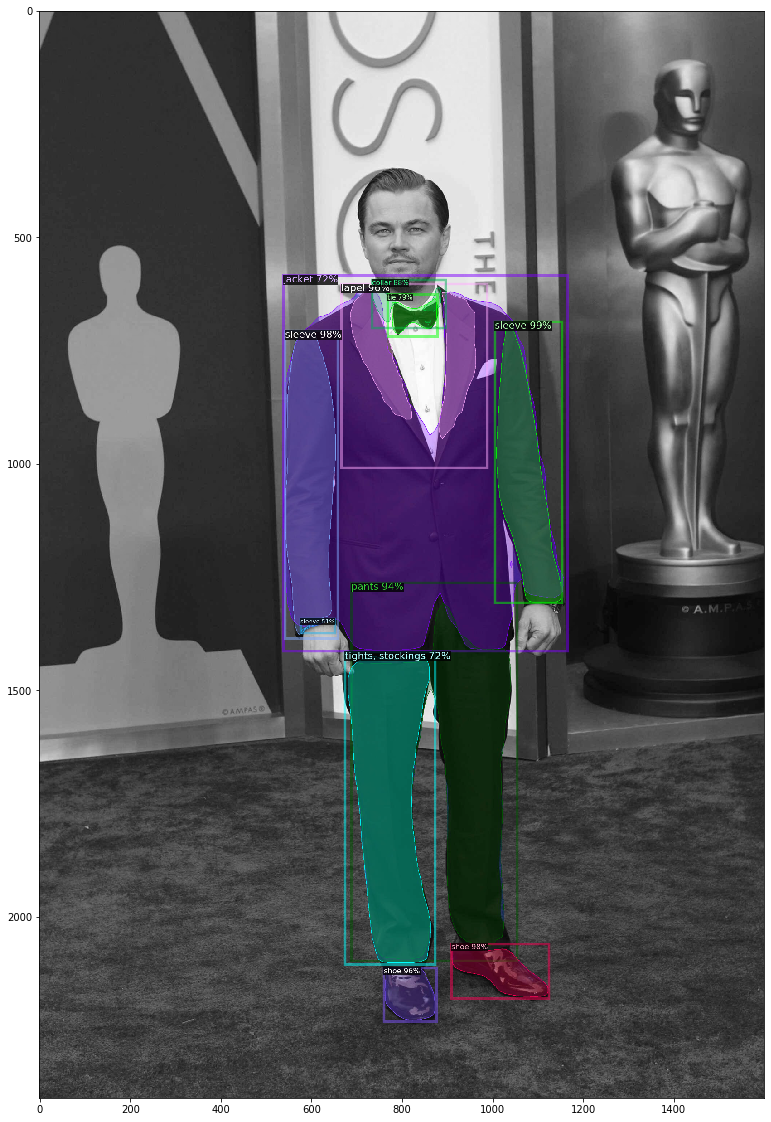

In [0]:
fashion_metadata = MetadataCatalog.get("test_sample_fashion_val")
predictor = DefaultPredictor(cfg)
from detectron2.utils.visualizer import ColorMode
plt.figure(figsize=(20,20))
for d in random.sample(fashion_dict, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=fashion_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.imshow(v.get_image()[:, :, ::-1])

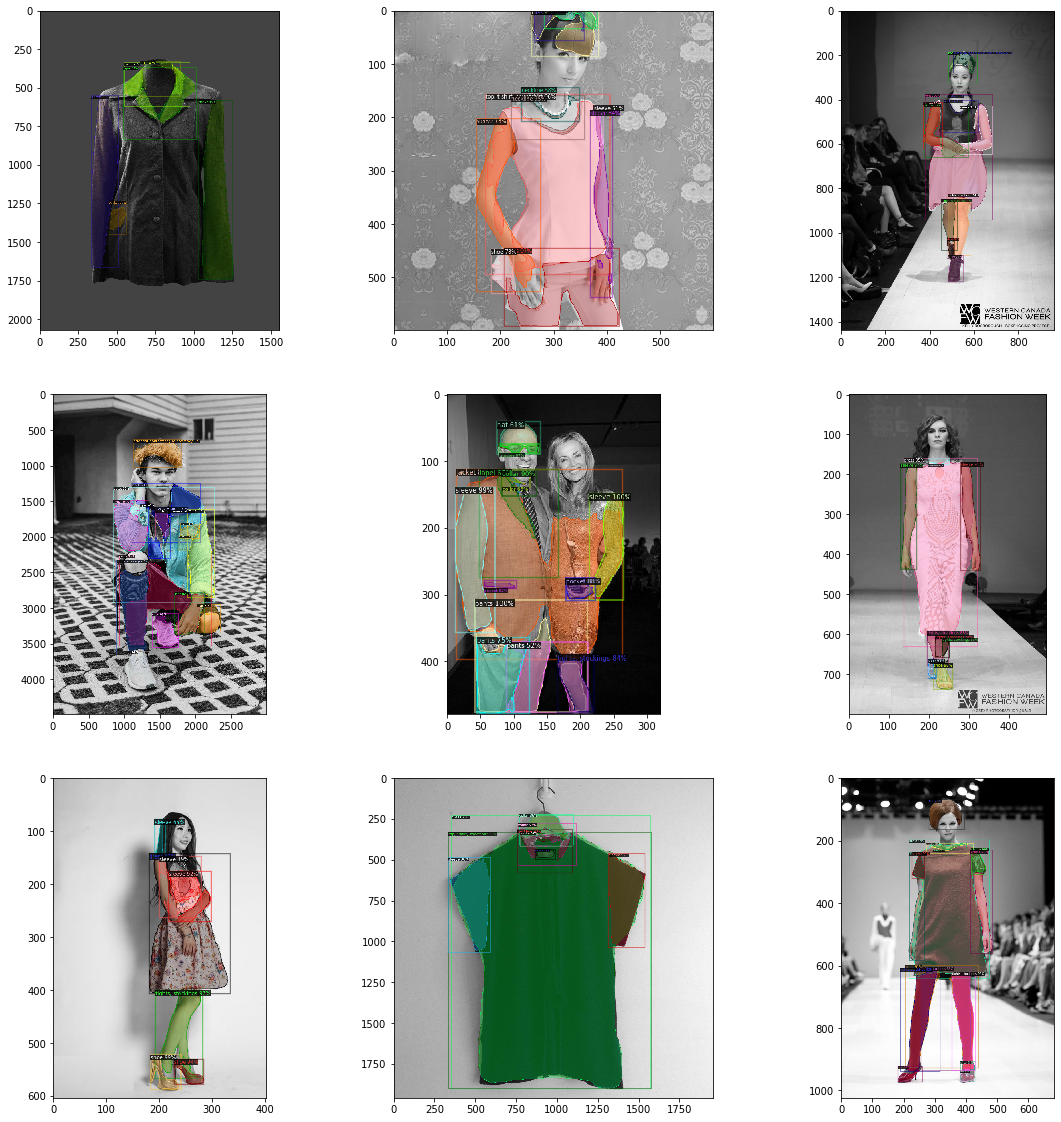

In [0]:
rows, cols = 3, 3
plt.figure(figsize=(20,20))

for i, d in enumerate(random.sample(fashion_dict, 9)):
    
    # Process image
    plt.subplot(rows, cols, i+1)

    im = cv2.imread(d["file_name"])
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    
    # Run through predictor
    outputs = predictor(im)
    
    # Visualize
    v = Visualizer(im[:, :, ::-1],
                   metadata=fashion_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.imshow(v.get_image()[:, :, ::-1])

plt.show()

In [0]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
#trainer = DefaultTrainer(cfg)
#trainer2 = DefaultTrainer(cfg)
#trainer2.resume_or_load(resume=False)
#trainer = DefaultTrainer(cfg)
from detectron2.modeling import build_model
model = build_model(cfg)
from detectron2.checkpoint import DetectionCheckpointer
file_path='/mount/ws/output_13May2020/model_final.pth'
DetectionCheckpointer(model).load(file_path)
#print(model)
evaluator = COCOEvaluator("test_sample_fashion_val", cfg, False, output_dir="/mount/ws/output_13May2020")
val_loader = build_detection_test_loader(cfg, "test_sample_fashion_val")
inference_on_dataset(model, val_loader, evaluator)
# another equivalent way is to use trainer.test

[05/16 20:57:43 d2.data.common]: Serializing 983 elements to byte tensors and concatenating them all ...
[05/16 20:57:44 d2.data.common]: Serialized dataset takes 24.76 MiB
[05/16 20:57:44 d2.evaluation.evaluator]: Start inference on 983 images
[05/16 20:57:51 d2.evaluation.evaluator]: Inference done 11/983. 0.0569 s / img. ETA=0:11:27
[05/16 20:57:57 d2.evaluation.evaluator]: Inference done 24/983. 0.0489 s / img. ETA=0:08:41
[05/16 20:58:02 d2.evaluation.evaluator]: Inference done 38/983. 0.0468 s / img. ETA=0:07:19
[05/16 20:58:07 d2.evaluation.evaluator]: Inference done 47/983. 0.0466 s / img. ETA=0:07:36
[05/16 20:58:15 d2.evaluation.evaluator]: Inference done 58/983. 0.0461 s / img. ETA=0:08:08
[05/16 20:58:20 d2.evaluation.evaluator]: Inference done 74/983. 0.0464 s / img. ETA=0:07:22
[05/16 20:58:26 d2.evaluation.evaluator]: Inference done 87/983. 0.0459 s / img. ETA=0:07:02
[05/16 20:58:43 d2.evaluation.evaluator]: Inference done 104/983. 0.0472 s / img. ETA=0:08:16
[05/16 20:

OrderedDict([('bbox',
              {'AP': 15.804898312141102,
               'AP50': 25.01350083924691,
               'AP75': 17.017834761523947,
               'APs': 8.518306469993869,
               'APm': 13.288260440145406,
               'APl': 17.271720122900884,
               'AP-shirt, blouse': 2.0685127336263034,
               'AP-top, t-shirt, sweatshirt': 44.53923291994034,
               'AP-sweater': 0.0,
               'AP-cardigan': 0.0,
               'AP-jacket': 47.11940894603283,
               'AP-vest': 0.0,
               'AP-pants': 60.51209485669654,
               'AP-shorts': 33.58703195943284,
               'AP-skirt': 32.660474578840876,
               'AP-coat': 13.22975374460523,
               'AP-dress': 70.98599821396243,
               'AP-jumpsuit': 0.0,
               'AP-cape': nan,
               'AP-glasses': 41.89708341837928,
               'AP-hat': 38.26033031392544,
               'AP-headband, head covering, hair accessory': 3.81726750